In [64]:
import rioxarray as rxr
import os
from rasterio.plot import show
from PIL import Image
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape
import pandas as pd

In [65]:
# retreive some infos on fully contained segments
fully_contained_file = 'data/fully_contained_segments.txt'
contained_file_minimum = 'data/contained_segments_minimum_copy.txt'
contained_file = 'data/contained_segments.txt'

In [84]:
# load the data
with open(fully_contained_file) as f:
    lines = f.readlines()
    # reteive line infos
    segment_id = []
    polygon_id = []
    class_id = []
    pixels = []
    for line in lines:
        # retrieve segment id
        segment_id.append(line.split(',')[0].split(':')[1].strip())
        # retrieve polygon id
        polygon_id.append(line.split(',')[1].split(':')[1].strip())
        # retrieve class id
        class_id.append(line.split(',')[2].split(':')[1].strip())
        # retrieve pixels
        pixel_list_str = line.split(':')[4]
        pixel_list_str = pixel_list_str[3:-3]
        pixel_list = list(pixel_list_str.split('], ['))
        pixel_list = [pixel.split(', ') for pixel in pixel_list]
        pixel_list = [[int(pixel[0]), int(pixel[1])] for pixel in pixel_list]
        pixels.append(pixel_list)
    
    # create a dataframe
    df_full = pd.DataFrame()
    df_full['segment_id'] = segment_id
    df_full['polygon_id'] = polygon_id
    df_full['class_id'] = class_id
    df_full['pixels'] = pixels

In [74]:
import pandas as pd
import re

# Initialize lists to store the data
segment_id = []
polygon_id = []
class_id = []
pixels = []

# Open and read the file
with open(contained_file) as f:  # Replace "your_file.txt" with the actual file path
    current_entry = ''
    for line in f:
        if line.startswith("Segment ID:"):
            # If a new entry starts, process the previous entry
            if current_entry:
                parts = re.split(r', |: |, |[ \[\]\n]', current_entry)
                # Check if there are enough parts to extract values
                if len(parts) >= 14:
                    # Extract segment ID, polygon ID, and class ID
                    segment_id.append(int(parts[2]))
                    polygon_id.append(float(parts[5]))
                    class_id.append(float(parts[8]))

                    # Extract pixel coordinates if they exist
                    pixel_pairs = []
                    for i in range(10, len(parts), 2):
                        if parts[i] and parts[i+1]:
                            pixel_pairs.append([int(parts[i]), int(parts[i+1])])
                    pixels.append(pixel_pairs)

            current_entry = line
        else:
            current_entry += line

# Create a DataFrame
data = {
    'segment_id': segment_id,
    'polygon_id': polygon_id,
    'class_id': class_id,
    'pixels': pixels
}
df = pd.DataFrame(data)

In [85]:
df = df_full
#df = df

In [86]:
print(len(df["pixels"][20]))

16


Number of segments:  2324
Mean number of pixels per segment:  16.03141135972461
Number of fully contained segments per class: 
class_id
1.0    165
2.0    125
3.0     74
4.0    334
5.0    920
6.0    661
7.0      8
8.0     37
Name: segment_id, dtype: int64


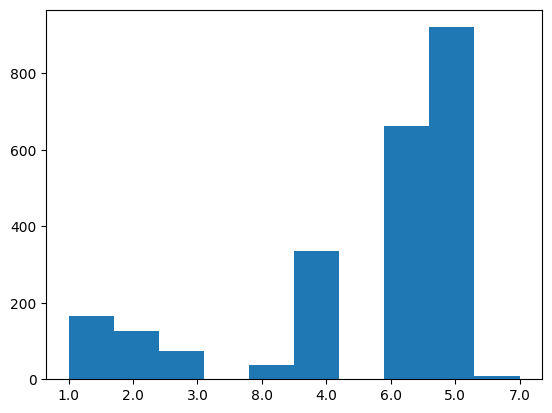

Number of fully contained segments per polygon: 


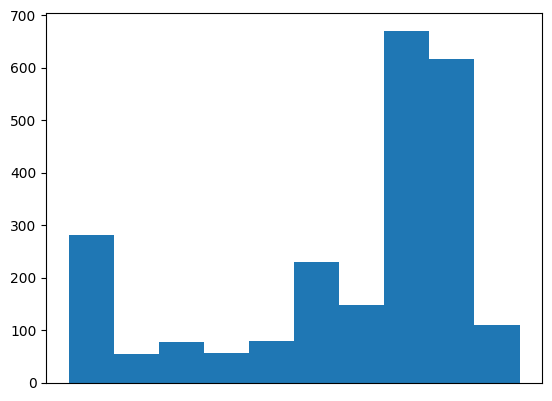

In [87]:
# show repartition, infos
print('Number of segments: ', len(df))
# show mean number of pixels per segment
print('Mean number of pixels per segment: ', np.mean([len(pixels) for pixels in df['pixels']]))

print('Number of fully contained segments per class: ')
print(df.groupby('class_id').count()['segment_id'])
# show the repartition using histogram
plt.hist(df['class_id'])
plt.show()

print('Number of fully contained segments per polygon: ')
#print(fully_contained_segments_df.groupby('polygon_id').count()['segment_id'])
# show the repartition using histogram
plt.hist(df['polygon_id'])
# remove x labels
plt.xticks([])
plt.show()

In [ ]:
folder = "/shared"

list_bands = ['02', '03', '04', '05', '06', '07', '08', '8A', '11', '12']

band_files = [os.path.join(folder, 's2_2020_B' + band + '.tif') for band in list_bands]


In [ ]:
def clip_all_acquisition(band):
    with rasterio.open(band) as src:
        for acquisition in range(1, 74):
            data_array = src.read(acquisition)
            min_val = np.percentile(data_array, 2)
            max_val = np.percentile(data_array, 98)
            norm_data = np.clip( (data_array - min_val) / (max_val - min_val), 0, 1)
            
    return norm_data

In [ ]:
normalized_data_bands = []
for bands in band_files:
    normalized_data_bands.append(clip_all_acquisition(bands))

- Satellite raster data (Sentinel 2)
	- 10 spectral bands, one per file (s2_2020_B02.tif, s2_2020_B03.tif, etc...)
	- Each file s2_2020_BXX.tif: contains an array of size (73, 4513, 5183)=(nb. dates, height, width).

In [ ]:
acquisition = 73
def get_7310(pixel):
    x = pixel[0]
    y = pixel[1]
    pixel_7310 = []
    for band in normalized_data_bands:
        for period in acquisition:
            pixel_7310.append(bands[acquisition, x, y])
    return pixel_7310